In the EDA section we've gained some knowledge about the dataset. 

Now, we will try to formulate the problem of predicting the probabilty of a customer placing a new order in the horizon of the next 30 days. We will also prepare some features to help us with this estimation.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import pandas as pd
from pandas import DataFrame
import seaborn as sns

from utilities import df_utils, clustering_utils

## Data import

We'll start by importing the data. From the EDA we know there are some duplications we will need to take care of.

In [2]:
data_path = '../data/raw_data.csv'
df = pd.read_csv(data_path)
df['created_at'] = pd.to_datetime(df['created_at'])
df.drop_duplicates(subset=['order_id', 'customer_id'], inplace=True)
df_utils.df_summarise(df)

(21444, 7)

Index(['order_id', 'customer_id', 'created_at', 'total_price', 'shipping_zip',
       'billing_zip', 'segment'],
      dtype='object')

,order_id,customer_id,created_at,total_price,shipping_zip,billing_zip,segment
0,1158820823102,1399261528126,2019-08-13 03:08:30,3192.00,8700,8700,4
1,1856685080638,2733349404734,2019-11-07 06:17:09,135.15,9000,9000,3
2,1994825334846,2862876164158,2019-12-25 14:47:26,288.00,8722,8722,3
3,2116997972030,2888199700542,2020-02-20 09:15:17,237.00,3650,3650,6
4,2155705139262,2992745709630,2020-03-13 22:57:46,208.00,9900,9900,3


## Problem formulation

We want to find out how likely a customer (identified by `customer_id`) is to make another purchase in the next 30 days. To formulate the problem numerically we will take the following steps:

1. Set aside all transactions pertaining to a 30 day period closer to the end of the analysis period
1. Use the transactions preceding this 30 day window as the dataset for analysing customer behaviour
1. The features used for modelling will be aggregated at a customer level to allow per customer prediction
1. Our target variable will be called `makes_purchase` and will be:
  * 1 for a customer if this customer makes any transaction in the 30 day period 
  * 0 otherwise

Let's start with the 30 day prediction window. The final transaction date for our dataset is 10-8-2021. To simplify and remove any potential intra-month seasonalities, we will set our prediction window to the 30 days of July 2021:

In [3]:
prediction_window = df[
    df['created_at'].between(
        pd.Timestamp(2021, 7, 1),
        pd.Timestamp(2021, 7, 30)
    )
].copy()
df_utils.df_summarise(prediction_window)

(1599, 7)

Index(['order_id', 'customer_id', 'created_at', 'total_price', 'shipping_zip',
       'billing_zip', 'segment'],
      dtype='object')

,order_id,customer_id,created_at,total_price,shipping_zip,billing_zip,segment
22480,3977821880382,1389230620734,2021-07-01 03:17:40,260.00,2650,2650,11
22481,3977884926014,1390240825406,2021-07-01 04:10:33,229.00,4600,4600,11
22482,3977908781118,1390033174590,2021-07-01 04:30:48,294.35,5580,5580,11
22483,3977954590782,5215938052158,2021-07-01 04:57:14,323.00,2980,2980,11
22484,3977988440126,5215963578430,2021-07-01 05:28:30,118.00,7400,7400,11


This means out behavioural dataset will be transactions prior to July 2021. From the EDA we know that prior to October 2020 there has been very little movement in the business (perhaps it was still fledgeling then..?). To make the analysis more statistically meaningful, we will limit the behavioural dataset to the period between October 2020 - June 2021:

In [4]:
behaviour_dataset = df[
    df['created_at'].between(
        pd.Timestamp(2020, 10, 1),
        pd.Timestamp(2021, 6, 30)
    )
].copy()
df_utils.df_summarise(behaviour_dataset)

(18946, 7)

Index(['order_id', 'customer_id', 'created_at', 'total_price', 'shipping_zip',
       'billing_zip', 'segment'],
      dtype='object')

,order_id,customer_id,created_at,total_price,shipping_zip,billing_zip,segment
63,2679892213822,3493717180478,2020-10-01 12:46:56,2445.00,8700,8700,3
64,2679964860478,3493777768510,2020-10-01 13:32:38,448.00,5000,5000,3
65,2679974887486,3490993078334,2020-10-01 13:38:06,2293.60,6000,6000,3
66,2680064802878,3433191145534,2020-10-01 14:28:48,438.95,2800,2800,3
67,2680986140734,3494350880830,2020-10-01 21:11:57,399.05,2620,2620,3


For convenience we'll create a Pandas groupby object relating to the customer, since this will be the aggregation used for forecasting:

In [5]:
customer_behaviour = behaviour_dataset.groupby('customer_id')

Let's see how many customers will form part of the dataset:

In [6]:
customers = pd.DataFrame(behaviour_dataset['customer_id'].unique(), columns=['customer_id'])
len(customers)

16599

Now let's create the target variable according to the methodolgy described earlier:

In [7]:
customers['makes_purchase'] = customers['customer_id'].isin(prediction_window['customer_id'].unique()).astype(int)
customers['makes_purchase'].describe()

count    16599.000000
mean         0.011326
std          0.105822
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: makes_purchase, dtype: float64

The stats for our target variable confirm our observations from the EDA: only ~1% of the analysed customer group made a purchase in our prediction window. This will make effective prediction of the target variable challenging due to a problem well known in the data science world: significant class imbalance.

Nevertheless, we'll try to use what we have to formulate features that can help us predict the target variable.

### RFM

We'll start with clustering our customers using the popular RFM (Recency / Frequency / Monetary) scheme. This will allow us (and hopefully the model) to gain a better understanding of the individual customer in the context of our total dataset.

The core idea here is to perform the following steps:
1. rank customers according to sales recency
1. rank customers according to sales frequency
1. rank customers according to sales value - i.e. revenue
1. use the above ranks to formulate an overall RFM score for customers
1. aggregate RFM scores to cluster customers into low, mid and high performing

**Recency**

Describes the overall inactivity of a customer in terms of making transactions in days: the higher value of `recency`, the longer a particular client has been inactive for. 

Since most of our customers only made a single transaction, we'll simplify this to counting the difference in days between the most recent customer transaction in our dataset and the most recent transaction of an individual client:

In [8]:
last_customer_transaction = (customer_behaviour
                                ['created_at'].max()
                                .reset_index()
                                .rename(columns={'created_at': 'last_transaction_date'}))

last_customer_transaction['recency'] = (
    last_customer_transaction['last_transaction_date'].max() - last_customer_transaction['last_transaction_date']
    ).dt.days

df_utils.df_summarise(last_customer_transaction)

(16599, 3)

Index(['customer_id', 'last_transaction_date', 'recency'], dtype='object')

,customer_id,last_transaction_date,recency
0,1385018720318,2021-06-15 08:39:50,14
1,1388893896766,2020-12-10 11:03:06,201
2,1388896190526,2020-11-14 10:07:51,227
3,1388901335102,2021-01-29 08:04:07,151
4,1388901859390,2021-06-08 05:39:32,21


Let's dive into the details of our new feature:

count    16599.000000
mean       143.816073
std         72.760413
min          0.000000
25%         85.000000
50%        159.000000
75%        209.000000
max        271.000000
Name: recency, dtype: float64

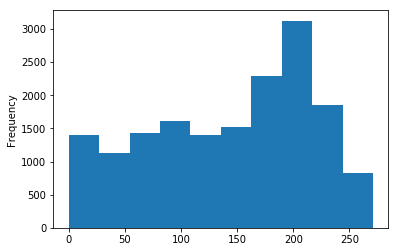

In [9]:
df_utils.show_stats(last_customer_transaction, 'recency')

There is a big concentration of clients around the 200 mark, meaning a lot of the customers that made business at the start of the analysed behaviural period never came back. This is consistent with the low per-customer number of transations and the imbalance in the target variable we saw earlier.

To segment the clients according to `recency` we will use the K-Means algorithm in the following steps:
1. analyse the optimal number of K-Means clusters [using the elbow method](https://www.scitepress.org/Papers/2019/99084/99084.pdf)
1. perform clustering with the optimal cluster number
1. rank clusters according to average cluster value - for `recency` a higher customer rank is assigned for lower value of recency

We have some utility functions to help with the analysis. Let's start with the elbow method:

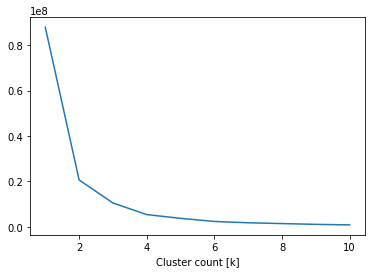

In [10]:
clustering_utils.plot_kmeans_elbow(last_customer_transaction[['recency']])

Looks like 4 is the optimal cluster number for `recency`. Time to create the recency ranking:

In [11]:
recency_df = clustering_utils.ordered_clustering(
    last_customer_transaction,
    n_clusters=4,
    cluster_by_column_name='recency', 
    ascending=False
    )

,count,mean,std,min,25%,50%,75%,max
recency_score,,,,,,,,
0,5301.0,222.893982,18.738943,195.0,211.0,217.0,235.0,271.0
1,4526.0,165.880027,16.933055,132.0,152.0,165.0,179.0,194.0
2,3773.0,96.483965,18.015504,64.0,81.0,99.0,111.0,131.0
3,2999.0,30.288429,18.541944,0.0,14.0,28.0,46.0,63.0


**Frequency**

Frequency describes the total number of transactions made by a client in the behaviour analysis period:

In [12]:
frequency = (
    customer_behaviour
        ['order_id'].count()
        .reset_index()
        .rename(columns={'order_id': 'frequency'})
        )
df_utils.df_summarise(frequency)

(16599, 2)

Index(['customer_id', 'frequency'], dtype='object')

,customer_id,frequency
0,1385018720318,1
1,1388893896766,1
2,1388896190526,1
3,1388901335102,1
4,1388901859390,1


count    16599.000000
mean         1.141394
std          0.467213
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         15.000000
Name: frequency, dtype: float64

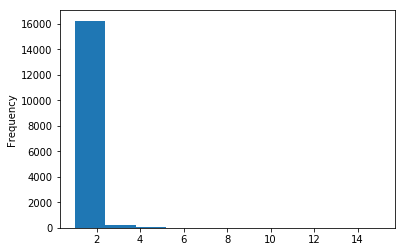

In [13]:
df_utils.show_stats(frequency, 'frequency')

This again highlights the fact most of the customers shop only once in the behaviour analysis period.

The ranking steps are analogous to `recency` with the ony difference being a higher rank is assigned with higher `frequency`:

/mnt/d/coding/git/TomaszKaleczyc/customer_order_prediction/src/utilities/clustering_utils.py:31: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_clusters, max_iter=max_iter).fit(df)


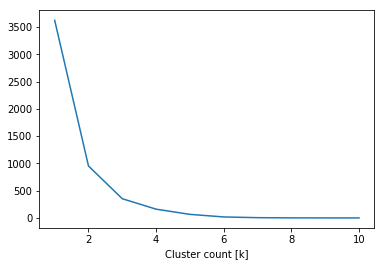

In [14]:
clustering_utils.plot_kmeans_elbow(frequency[['frequency']])

In [15]:
frequency_df = clustering_utils.ordered_clustering(
    frequency,
    n_clusters=4,
    cluster_by_column_name='frequency', 
    ascending=True
    )

,count,mean,std,min,25%,50%,75%,max
frequency_score,,,,,,,,
0,14765.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
1,1480.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
2,322.0,3.217391,0.413113,3.0,3.0,3.0,3.0,4.0
3,32.0,5.781250,1.844510,5.0,5.0,5.0,6.0,15.0


As expected, the vast majority of customers land in the lowest rank.

**Monetary**

We will also calculate the total value of the client expressed as the sum of transation amounts in the analysed period:

In [16]:
revenue = (customer_behaviour
            ['total_price'].sum()
            .reset_index()
            .rename(columns={'total_price': 'total_revenue'})
            )
df_utils.df_summarise(revenue)

(16599, 2)

Index(['customer_id', 'total_revenue'], dtype='object')

,customer_id,total_revenue
0,1385018720318,0.0
1,1388893896766,158.0
2,1388896190526,208.0
3,1388901335102,54.2
4,1388901859390,178.0


count    16599.000000
mean       427.478473
std        544.934803
min          0.000000
25%        180.200000
50%        300.750000
75%        488.000000
max      31472.800000
Name: total_revenue, dtype: float64

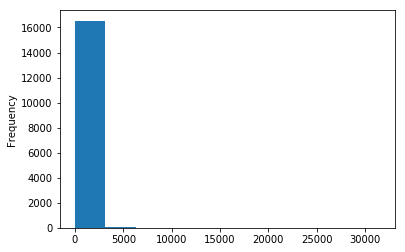

In [17]:
df_utils.show_stats(revenue, 'total_revenue')

With the exception of some outliers, the revenue amounts seem to be concentrated around 300 - consistent with our EDA findings. 

Time for ranking - again: the higher the `total_revenue`, the higher the ranking:

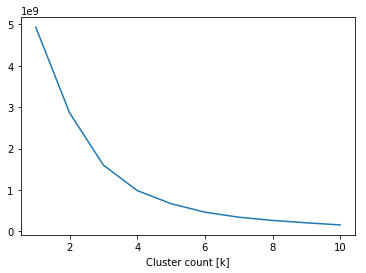

In [18]:
clustering_utils.plot_kmeans_elbow(revenue[['total_revenue']])

In [19]:
revenue_df = clustering_utils.ordered_clustering(
    revenue,
    n_clusters=4,
    cluster_by_column_name='total_revenue', 
    ascending=True
    )

,count,mean,std,min,25%,50%,75%,max
total_revenue_score,,,,,,,,
0,13781.0,277.510895,137.435581,0.00,173.93,238.00,375.99,618.80
1,2529.0,959.680708,305.760805,618.92,717.60,879.53,1116.00,1856.25
2,287.0,2757.227282,1240.356260,1861.55,2090.75,2394.00,2921.87,13133.25
3,2.0,26490.400000,7046.177653,21508.00,23999.20,26490.40,28981.60,31472.80


The final rank consists only of the two outliers - this could be something to potentially exclude from the dataset at some point. We'll keep them in for now as these will be grouped with the others in the RFM score and segmentation phases.

**RFM Score**

Since we established an ordinal relationship in the previous scores, we will formulate the RFM Score simply as a sum of the previous scores:

In [20]:
features = (
    customers
    .merge(recency_df, how='left', on='customer_id')
    .merge(frequency_df, how='left', on='customer_id')
    .merge(revenue_df, how='left', on='customer_id')
    )
features['rfm_score'] = features['recency_score'] + features['frequency_score'] + features['total_revenue_score']
features.groupby('rfm_score').agg(['mean', 'count'])[['recency','frequency','total_revenue']]


recency        frequency       total_revenue      
                 mean count       mean count          mean count
rfm_score                                                       
0          223.164661  4239   1.000000  4239    283.135152  4239
1          177.474183  4222   1.038134  4222    372.407556  4222
2          115.616878  3863   1.103288  3863    404.912765  3863
3           54.374573  3217   1.165061  3217    433.890289  3217
4           71.241641   658   1.788754   658   1028.468116   658
5           64.938628   277   2.454874   277   1452.850939   277
6           45.954545    88   3.272727    88   1623.421250    88
7           43.321429    28   4.107143    28   2480.889286    28
8           40.600000     5   6.400000     5   3743.800000     5
9           18.000000     2  11.000000     2  26490.400000     2

As described earlier, we can further group the clients based on the RFM Scores into three categories: low, mid and high performing. 

Since the sales frequency seems to be one of the bigger challenges ahead of us, it makes sense to separate the low frequency (~1 sale) customers from the high performing ones. Therefore for our final segmentation, we will group 0-3 as low, 4 as mid and 5-9 as high:

In [21]:
get_rfm_segment = lambda rfm_score: 'high' if rfm_score >= 5 else 'mid' if rfm_score >= 4 else 'low'

features['rfm_segment'] = features['rfm_score'].apply(get_rfm_segment)
features.groupby('rfm_segment').agg(['mean', 'count'])[['recency','frequency','total_revenue']]

recency        frequency        total_revenue       
                   mean  count      mean  count          mean  count
rfm_segment                                                         
high          58.710000    400  2.842500    400   1716.163700    400
low          149.079339  15541  1.070201  15541    368.864145  15541
mid           71.241641    658  1.788754    658   1028.468116    658

We can analyse the segmentation with respect to how it separates the customer groups according the the RFM features:

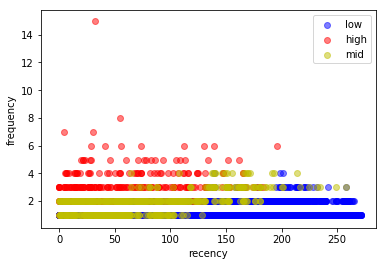

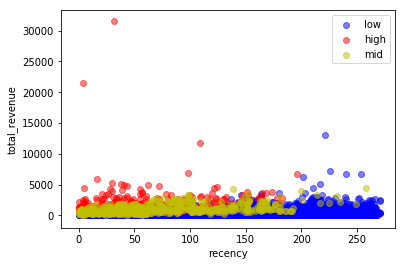

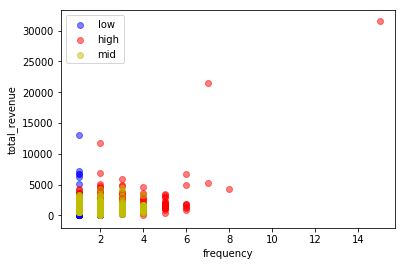

In [22]:
def scatterplot_segments(df: DataFrame, segment_column_name: str, feature_1: str, feature_2: str):
    """
    Shows segmentation scatterplot
    """
    segments = df[segment_column_name].unique()
    plt.figure()
    for segment in segments:
        color = 'r' if segment == 'high' else 'y' if segment == 'mid' else 'b'
        segment_df = df[df[segment_column_name] == segment]
        plt.scatter(segment_df[feature_1], segment_df[feature_2], c=color, alpha=0.5, label=segment)
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.legend()
    plt.show()

scatterplot_segments(features, 'rfm_segment', 'recency', 'frequency')
scatterplot_segments(features, 'rfm_segment', 'recency', 'total_revenue')
scatterplot_segments(features, 'rfm_segment', 'frequency', 'total_revenue')

The segments appear to be reasonably well separated.

### Geographical features

As described in the EDA part, we'll use the stem of the billing ZIP code as a feature in the model:

In [23]:
zip_codes = behaviour_dataset[['customer_id', 'billing_zip']].drop_duplicates(subset='customer_id')
zip_codes['billing_zip_stem'] = zip_codes['billing_zip'].apply(df_utils.get_zip_code_stem)

features = features.merge(
    zip_codes[['customer_id', 'billing_zip_stem']], 
    how='left', 
    on='customer_id'
    )

df_utils.df_summarise(features)

(16599, 12)

Index(['customer_id', 'makes_purchase', 'last_transaction_date', 'recency',
       'recency_score', 'frequency', 'frequency_score', 'total_revenue',
       'total_revenue_score', 'rfm_score', 'rfm_segment', 'billing_zip_stem'],
      dtype='object')

,customer_id,makes_purchase,last_transaction_date,recency,recency_score,frequency,frequency_score,total_revenue,total_revenue_score,rfm_score,rfm_segment,billing_zip_stem
0,3493717180478,0,2020-10-01 12:46:56,271,0,1,0,2445.00,2,2,low,87
1,3493777768510,0,2020-10-01 13:32:38,271,0,1,0,448.00,0,0,low,50
2,3490993078334,0,2020-10-01 13:38:06,271,0,1,0,2293.60,2,2,low,60
3,3433191145534,0,2020-10-01 14:28:48,271,0,1,0,438.95,0,0,low,28
4,3494350880830,0,2020-10-01 21:11:57,271,0,1,0,399.05,0,0,low,26


### Segmentation

Lastly, well add the original `segment` feature and see how it compares to the RFM segmentation we just prepared:

In [24]:
features = features.merge(customer_behaviour['segment'].max(), how='left', on='customer_id')

features[['rfm_score', 'segment']].corr()

,rfm_score,segment
rfm_score,1.000000,0.281274
segment,0.281274,1.000000


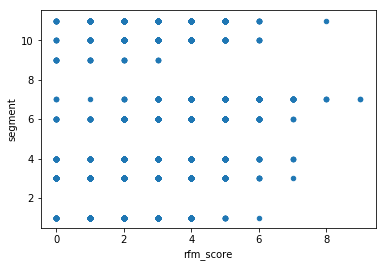

In [25]:
features[['rfm_score', 'segment']].plot.scatter(x='rfm_score', y='segment');

There seems to be some rather minor correlation between the two segmentation scores - in particular visible for higher values of both scores.

This concludes the feature engineering part of the analysis, the only thing left now is the save the refined dataset for modelling purposes:

In [26]:
features.to_csv('../data/features.csv')